Description : This notebook contains Actual vs Forecasts weather attributes comparison for November 2020 <br>
- Forecast and Actual Weather Attributes comparison which are used in the model <br>
- Sensitivity of Models while doing predictions using forecasts and actual weather attributes <br>

In [24]:
from IPython.display import HTML

HTML('''
<script src='//code.jquery.com/jquery-3.3.1.min.js'></script>
<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 $('div .jp-CodeCell .jp-Cell-inputWrapper').hide();
 } else {
 $('div.input').show();
 $('div .jp-CodeCell .jp-Cell-inputWrapper').show();
 }
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Code on/off"></form>''')

In [1]:
import csv
import math
import pickle
import datetime as dt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import sklearn

from scipy import stats
from dateutil.parser import parse
from datetime import datetime
from IPython.display import display_html
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from pprint import pprint
from sklearn.preprocessing import OrdinalEncoder
from catboost import CatBoostRegressor
from scipy.stats import linregress

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
plt.style.use('fivethirtyeight')
pd.options.display.float_format = '{:.2f}'.format

In [2]:
# read features used in random forest model
rf_model_features = pd.read_csv('gs://aes-analytics-0002-curated/Outage_Restoration/Model_object/Random_Forest_GridSearch_09172020.csv', index_col=0)

# read analytical dataset with actual weather data 
df_ads_actuals = pd.read_csv("gs://aes-datahub-0002-curated/Outage_Restoration/IPL_Master_Dataset/OMS_November_Actuals.csv")

# read analytical dataset with forecats weather data
df_ads_forecats = pd.read_csv("gs://aes-analytics-0002-curated/Outage_Restoration/IPL_Master_Dataset/Oms_IPL_November_Forecasts.csv")

In [3]:
df_ads_actuals_v1 = df_ads_actuals.copy(deep=True)
df_ads_actuals_v1 = df_ads_actuals_v1[df_ads_actuals_v1.TTR>30]
df_ads_actuals_v1 = df_ads_actuals_v1[df_ads_actuals_v1.TTR<5000]
df_ads_actuals_v1 = pd.get_dummies(df_ads_actuals_v1, columns=['DAY_FLAG', 'POLE_CLUE_FLG', 'PART_LIGHT_CLUE_FLG', 'EMERGENCY_CLUE_FLG', 'POWER_OUT_CLUE_FLG', 
                                   'OPEN_DEVICE_CLUE_FLG', 'TREE_CLUE_FLG', 'WIRE_DOWN_CLUE_FLG', 'IVR_CLUE_FLG', 'EQUIPMENT_CLUE_FLG',
                                   'TRANSFORMER_CLUE_FLG', 'OH_CAUSE_FLG', 'UG_CAUSE_FLG', 'ANIMAL_CAUSE_FLG', 'WEATHER_CAUSE_FLG', 
                                   'WEATHER_COLD_CAUSE_FLG', 'PUBLIC_CAUSE_FLG', 'WEATHER_LIGHTNING_CAUSE_FLG', 'WEATHER__SNOW_CAUSE_FLG', 
                                   'WEATHER__WIND_CAUSE_FLG', 'WEATHER__HEAT_CAUSE_FLG', 'CUST_REQUEST_CAUSE_FLG', 'WEATHER__FLOOD_CAUSE_FLG', 
                                   'STREET_CAUSE_FLG', 'SUBSTATION_CAUSE_FLG', 'TREE_CAUSE_FLG', 'MISCELLANEOUS_CAUSE_FLG', 'NO_CAUSE_FLG', 
                                   'PLANNED_CAUSE_FLG', 'NO_OUTAGE_CAUSE_FLG', 'FUSE_OCCURN_FLG', 'CUST_EQUIP_OCCURN_FLG', 'POLE_OCCURN_FLG', 
                                   'TRANSFORMER_OCCURN_FLG', 'METER_OCCURN_FLG', 'SERVICE_OCCURN_FLG', 'CABLE_OCCURN_FLG', 'ST_OCCURN_FLG',
                                   'FIRE_OCCURN_FLG', 'FOUND_OPEN_OCCURN_FLG', 'PUBLIC_SAFETY_OCCURN_FLG', 'WIRE_OCCURN_FLG', 'SWITCH_OCCURN_FLG', 
                                   'REGULATOR_OCCURN_FLG', 'CUTOUT_OCCURN_FLG', 'CAP_BANK_OCCURN_FLG', 'RECLOSER_OCCURN_FLG', 'OH_OCCURN_FLG', 
                                   'PRIORITY_VAL_1.0', 'PRIORITY_VAL_2.0', 'PRIORITY_VAL_3.0', 'PRIORITY_VAL_5.0', 'CITY_NAM', 
                                   'ZONE', 'Weekday', 'Weekend_flag', 'Dispatch_Location'])

In [4]:
df_ads_forecats_v1 = df_ads_forecats.copy(deep=True)
df_ads_forecats_v1 = df_ads_forecats_v1[df_ads_forecats_v1.TTR>30]
df_ads_forecats_v1 = df_ads_forecats_v1[df_ads_forecats_v1.TTR<5000]
df_ads_forecats_v1 = pd.get_dummies(df_ads_forecats_v1, columns=['DAY_FLAG', 'POLE_CLUE_FLG', 'PART_LIGHT_CLUE_FLG', 'EMERGENCY_CLUE_FLG', 'POWER_OUT_CLUE_FLG', 
                                   'OPEN_DEVICE_CLUE_FLG', 'TREE_CLUE_FLG', 'WIRE_DOWN_CLUE_FLG', 'IVR_CLUE_FLG', 'EQUIPMENT_CLUE_FLG',
                                   'TRANSFORMER_CLUE_FLG', 'OH_CAUSE_FLG', 'UG_CAUSE_FLG', 'ANIMAL_CAUSE_FLG', 'WEATHER_CAUSE_FLG', 
                                   'WEATHER_COLD_CAUSE_FLG', 'PUBLIC_CAUSE_FLG', 'WEATHER_LIGHTNING_CAUSE_FLG', 'WEATHER__SNOW_CAUSE_FLG', 
                                   'WEATHER__WIND_CAUSE_FLG', 'WEATHER__HEAT_CAUSE_FLG', 'CUST_REQUEST_CAUSE_FLG', 'WEATHER__FLOOD_CAUSE_FLG', 
                                   'STREET_CAUSE_FLG', 'SUBSTATION_CAUSE_FLG', 'TREE_CAUSE_FLG', 'MISCELLANEOUS_CAUSE_FLG', 'NO_CAUSE_FLG', 
                                   'PLANNED_CAUSE_FLG', 'NO_OUTAGE_CAUSE_FLG', 'FUSE_OCCURN_FLG', 'CUST_EQUIP_OCCURN_FLG', 'POLE_OCCURN_FLG', 
                                   'TRANSFORMER_OCCURN_FLG', 'METER_OCCURN_FLG', 'SERVICE_OCCURN_FLG', 'CABLE_OCCURN_FLG', 'ST_OCCURN_FLG',
                                   'FIRE_OCCURN_FLG', 'FOUND_OPEN_OCCURN_FLG', 'PUBLIC_SAFETY_OCCURN_FLG', 'WIRE_OCCURN_FLG', 'SWITCH_OCCURN_FLG', 
                                   'REGULATOR_OCCURN_FLG', 'CUTOUT_OCCURN_FLG', 'CAP_BANK_OCCURN_FLG', 'RECLOSER_OCCURN_FLG', 'OH_OCCURN_FLG', 
                                   'PRIORITY_VAL_1.0', 'PRIORITY_VAL_2.0', 'PRIORITY_VAL_3.0', 'PRIORITY_VAL_5.0', 'CITY_NAM', 
                                   'ZONE', 'Weekday', 'Weekend_flag', 'Dispatch_Location'])

In [5]:
rf_final_feautres = list(rf_model_features.Features_List.unique())
print(rf_final_feautres)

['windDir100mAvg', 'POWER_OUT_CLUE_FLG_True', 'Hour_Cos', 'FUSE_OCCURN_FLG_False', 'NO_OF_IVR_CLUE_PER_DAY', 'NO_OF_POWER_OUT_CLUE_PER_DAY', 'Outages_in_last_1hr', 'Priority_Customer_Qty', 'ANIMAL_CAUSE_FLG_False', 'UG_CAUSE_FLG_False', 'tempRange', 'NO_OF_WIRE_OCCURN_PER_DAY', 'radSolarTot', 'PUBLIC_SAFETY_OCCURN_FLG_True', 'Outages_in_last_10hr', 'NO_CAUSE_FLG_False', 'cldCvrRange', 'windSpd80mMax', 'Hour_Sin', 'CALL_QTY', 'NO_OF_OPEN_DEVICE_CLUE_PER_DAY', 'TREE_CAUSE_FLG_True', 'Outages_in_last_2hr', 'TREE_CAUSE_FLG_False', 'Priority_Dist_Customer_Qty', 'relHumAvg', 'POLE_CLUE_FLG_False', 'DOWNSTREAM_CUST_QTY', 'Outages_in_last_9hr', 'heatIndexMax', 'DAY_FLAG_True', 'WIRE_OCCURN_FLG_False', 'ANIMAL_CAUSE_FLG_True', 'ST_OCCURN_FLG_False', 'CITY_NAM_NO_CITY', 'PUBLIC_SAFETY_OCCURN_FLG_False', 'ST_OCCURN_FLG_True', 'POWER_OUT_CLUE_FLG_False']


In [6]:
# subset actual weather data columns
actual_weather = df_ads_actuals[['Date', 'windDir100mAvg',  'tempRange', 'radSolarTot', 'cldCvrRange', 'windSpd80mMax', 'relHumAvg', 'heatIndexMax', 'Marker_Location']]

# subset forecasted weather data columns
forecast_weather = df_ads_forecats[['Date', 'windDir100mAvg',  'tempRange', 'radSolarTot', 'cldCvrRange', 'windSpd80mMax', 'relHumAvg', 'heatIndexMax', 'Marker_Location']]

In [7]:
merged_weather = pd.merge(actual_weather, forecast_weather, how='left', on=['Date', 'Marker_Location'], suffixes=('','_forecast'))
print(merged_weather.shape)
merged_weather.drop_duplicates(subset=['Date', 'Marker_Location'], keep='last', inplace=True)
merged_weather.reset_index(drop=True, inplace=True)
print(merged_weather.shape)
merged_weather.head()

(71322, 16)
(429, 16)


,Date,windDir100mAvg,tempRange,radSolarTot,cldCvrRange,windSpd80mMax,relHumAvg,heatIndexMax,Marker_Location,windDir100mAvg_forecast,tempRange_forecast,radSolarTot_forecast,cldCvrRange_forecast,windSpd80mMax_forecast,relHumAvg_forecast,heatIndexMax_forecast
0,2020-11-01 00:00:00,287.00,21.50,3189.10,31.00,31.90,58.60,52.70,Marker6,313.00,10.40,1564.80,26.00,28.20,41.50,43.20
1,2020-11-01 00:00:00,287.00,21.30,3430.90,31.00,29.90,55.50,52.90,Marker14,312.00,12.40,1600.00,0.00,28.50,45.60,44.20
2,2020-11-01 00:00:00,287.00,21.30,3122.10,40.00,32.60,62.00,52.60,Marker2,312.00,10.20,1550.50,55.00,28.40,42.20,42.70
3,2020-11-01 00:00:00,285.00,21.30,3377.00,32.00,29.50,55.70,53.30,Marker15,312.00,11.30,1583.80,0.00,28.10,41.90,44.50
4,2020-11-01 00:00:00,287.00,21.90,3546.90,24.00,29.90,54.80,53.60,Marker18,312.00,13.80,1600.20,0.00,29.50,48.90,44.10


## **Difference in actual and forecasted Weather Attributes?**

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

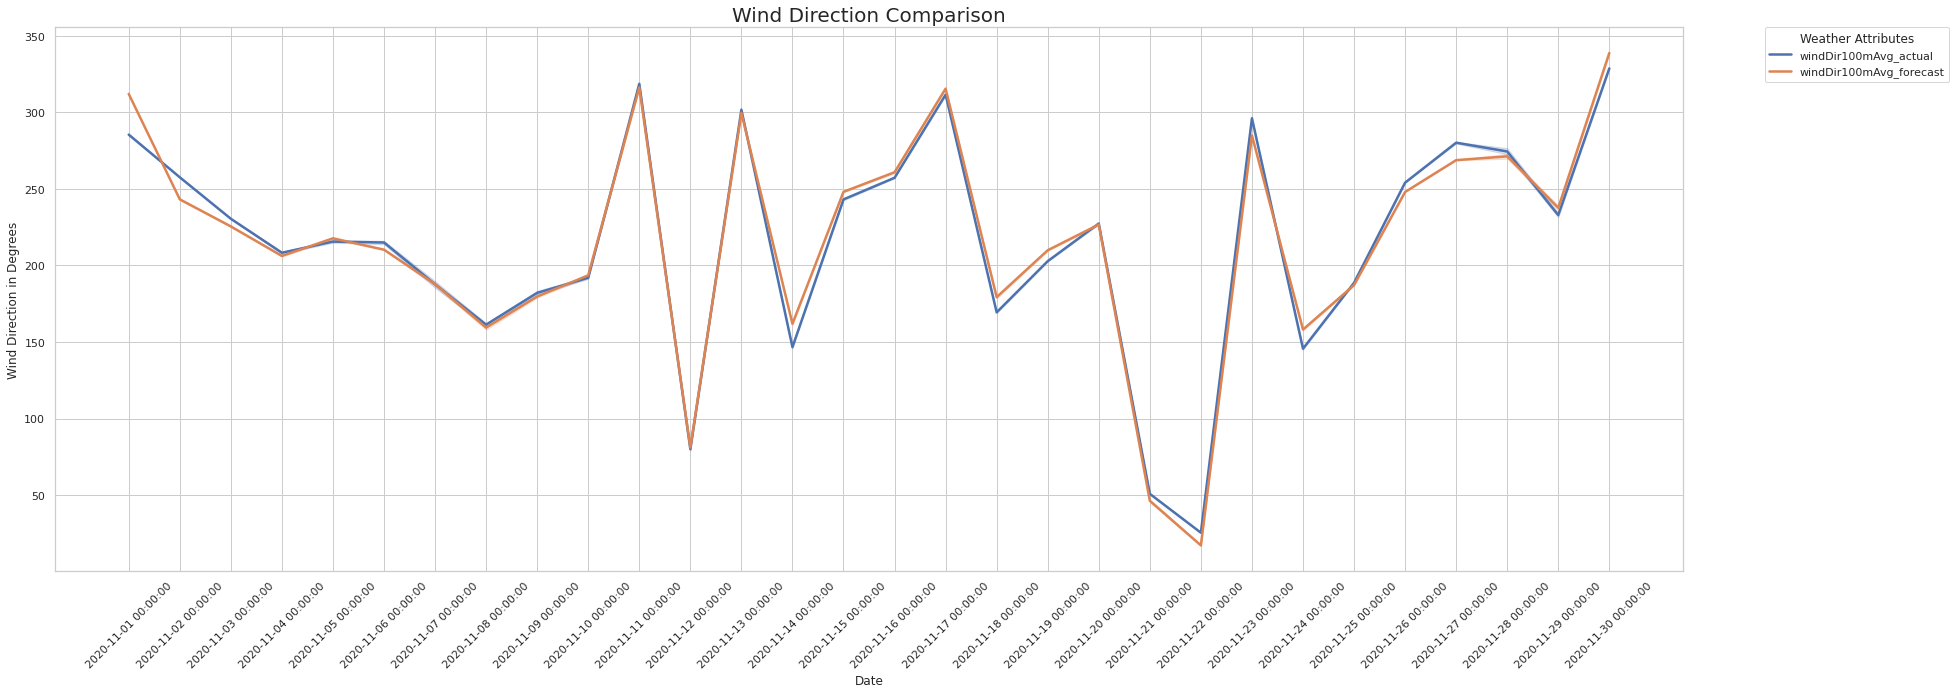

In [8]:
sns.set(rc={'figure.figsize':(26,10)})
sns.set_style("whitegrid")
with plt.rc_context({'lines.linewidth': 2.5}):
    ax = sns.lineplot(x='Date', y='value', hue='variable', 
                  data=pd.melt(merged_weather[['Date', 'windDir100mAvg', 'windDir100mAvg_forecast']], ['Date']))
    new_labels = ['windDir100mAvg_actual', 'windDir100mAvg_forecast']
sns.set(rc={"axes.titlesize":20,'figure.facecolor':'white','axes.facecolor':'white'},style="white")
ax.set(xlabel='Date', ylabel='Wind Direction in Degrees',title="Wind Direction Comparison")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., labels=new_labels, title='Weather Attributes')
plt.xticks(rotation=45)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

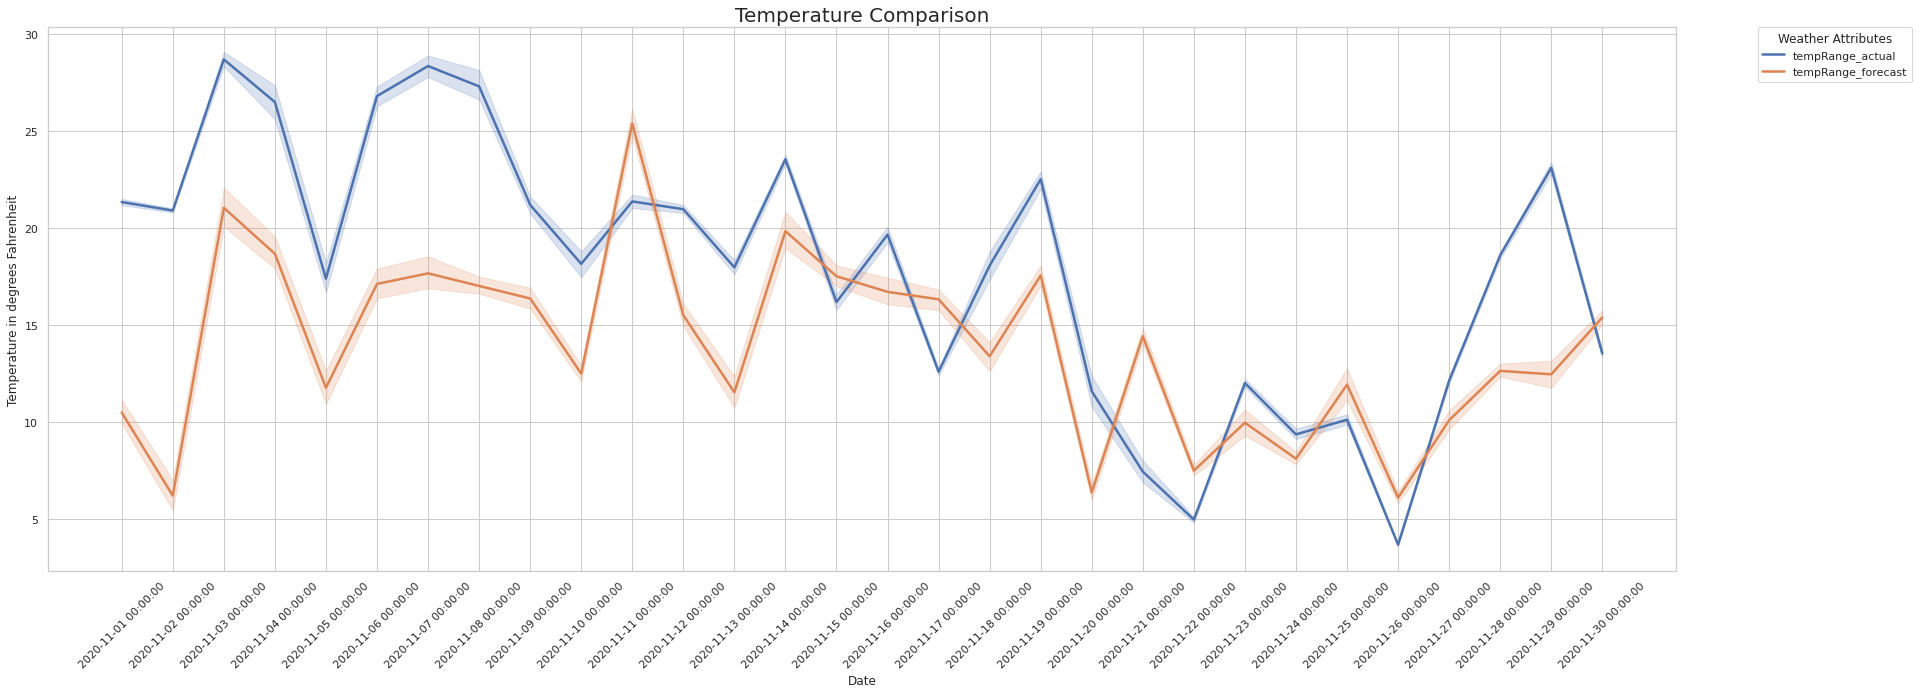

In [9]:
sns.set(rc={'figure.figsize':(26,10)})
sns.set_style("whitegrid")
with plt.rc_context({'lines.linewidth': 2.5}):
    ax = sns.lineplot(x='Date', y='value', hue='variable', 
                  data=pd.melt(merged_weather[['Date', 'tempRange', 'tempRange_forecast']], ['Date']))
    new_labels = ['tempRange_actual', 'tempRange_forecast']
sns.set(rc={"axes.titlesize":20,'figure.facecolor':'white','axes.facecolor':'white'},style="white")
ax.set(xlabel='Date', ylabel='Temperature in degrees Fahrenheit',title="Temperature Comparison")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., labels=new_labels, title='Weather Attributes')
plt.xticks(rotation=45)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

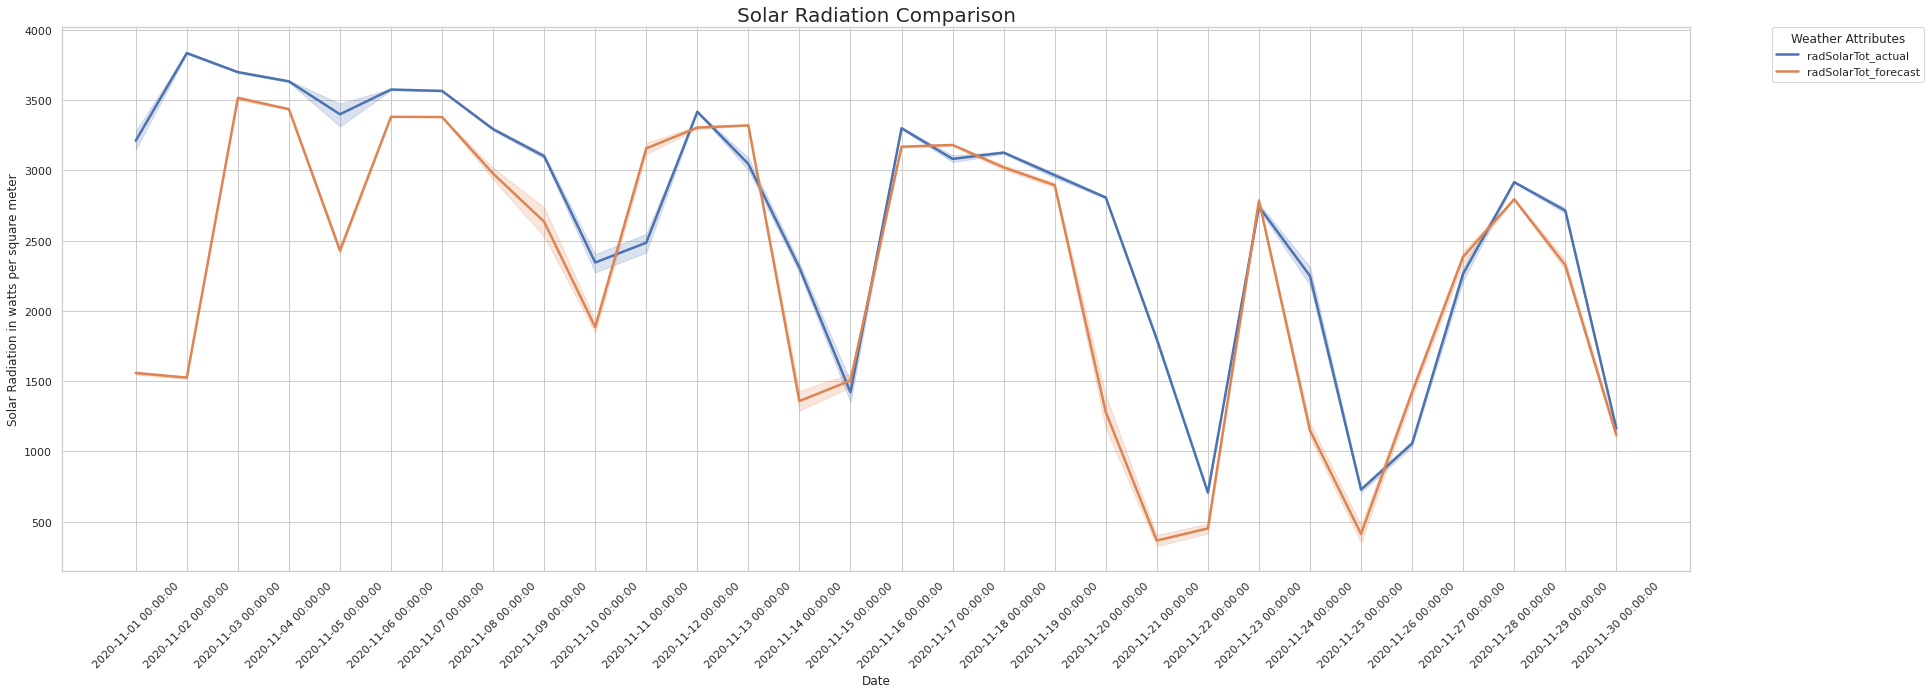

In [10]:
sns.set(rc={'figure.figsize':(26,10)})
sns.set_style("whitegrid")
with plt.rc_context({'lines.linewidth': 2.5}):
    ax = sns.lineplot(x='Date', y='value', hue='variable', 
                  data=pd.melt(merged_weather[['Date', 'radSolarTot', 'radSolarTot_forecast']], ['Date']))
    new_labels = ['radSolarTot_actual', 'radSolarTot_forecast']
sns.set(rc={"axes.titlesize":20,'figure.facecolor':'white','axes.facecolor':'white'},style="white")
ax.set(xlabel='Date', ylabel='Solar Radiation in watts per square meter',title="Solar Radiation Comparison")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., labels=new_labels, title='Weather Attributes')
plt.xticks(rotation=45)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

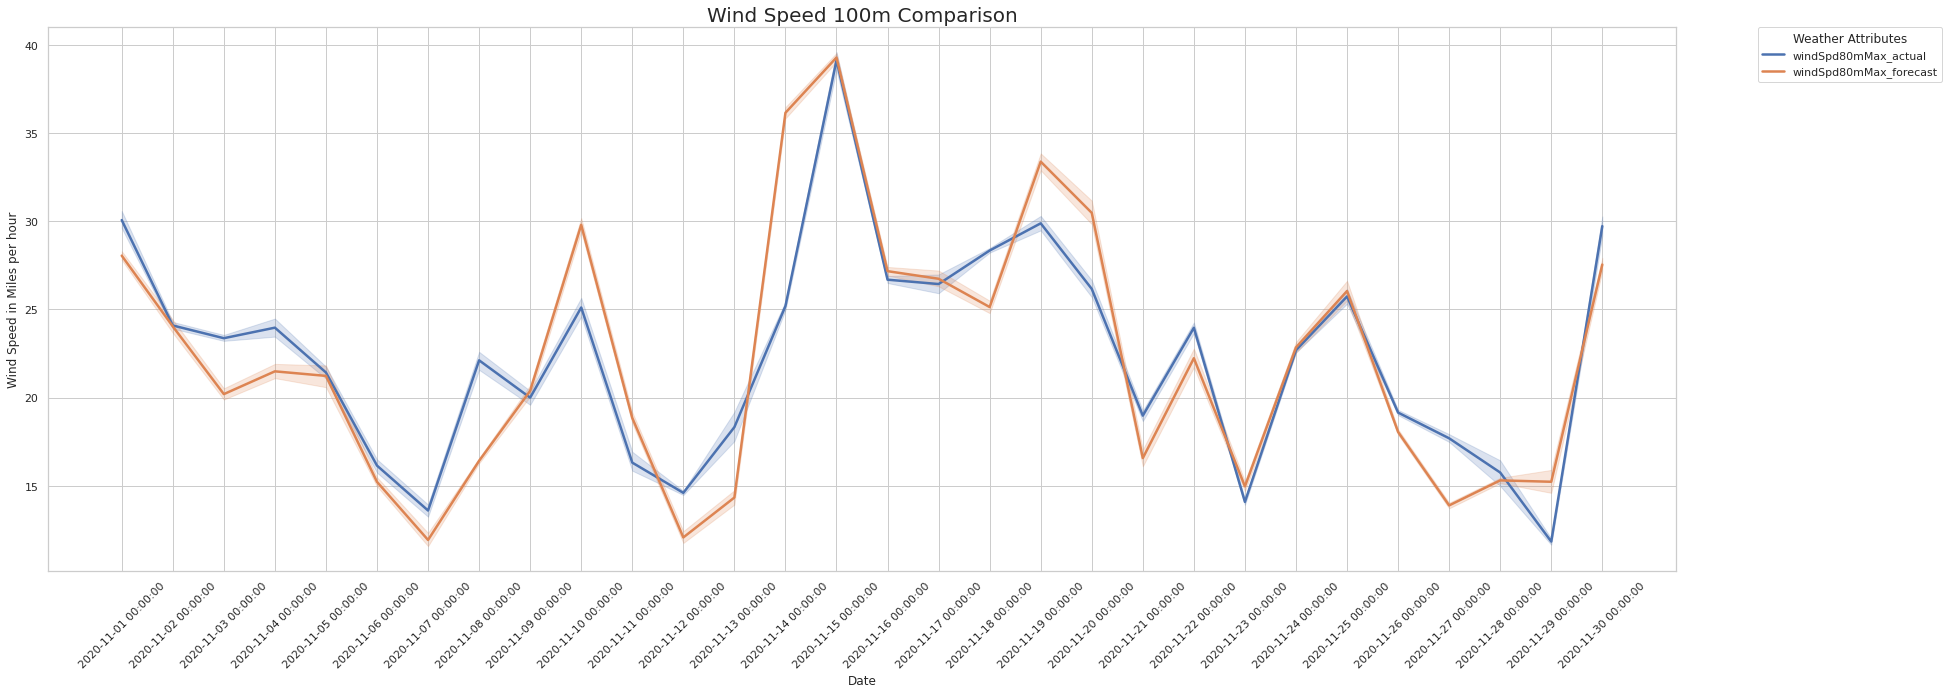

In [11]:
sns.set(rc={'figure.figsize':(26,10)})
sns.set_style("whitegrid")
with plt.rc_context({'lines.linewidth': 2.5}):
    ax = sns.lineplot(x='Date', y='value', hue='variable', 
                  data=pd.melt(merged_weather[['Date', 'windSpd80mMax', 'windSpd80mMax_forecast']], ['Date']))
    new_labels = ['windSpd80mMax_actual', 'windSpd80mMax_forecast']
sns.set(rc={"axes.titlesize":20,'figure.facecolor':'white','axes.facecolor':'white'},style="white")
ax.set(xlabel='Date', ylabel='Wind Speed in Miles per hour',title="Wind Speed 100m Comparison")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., labels=new_labels, title='Weather Attributes')
plt.xticks(rotation=45)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

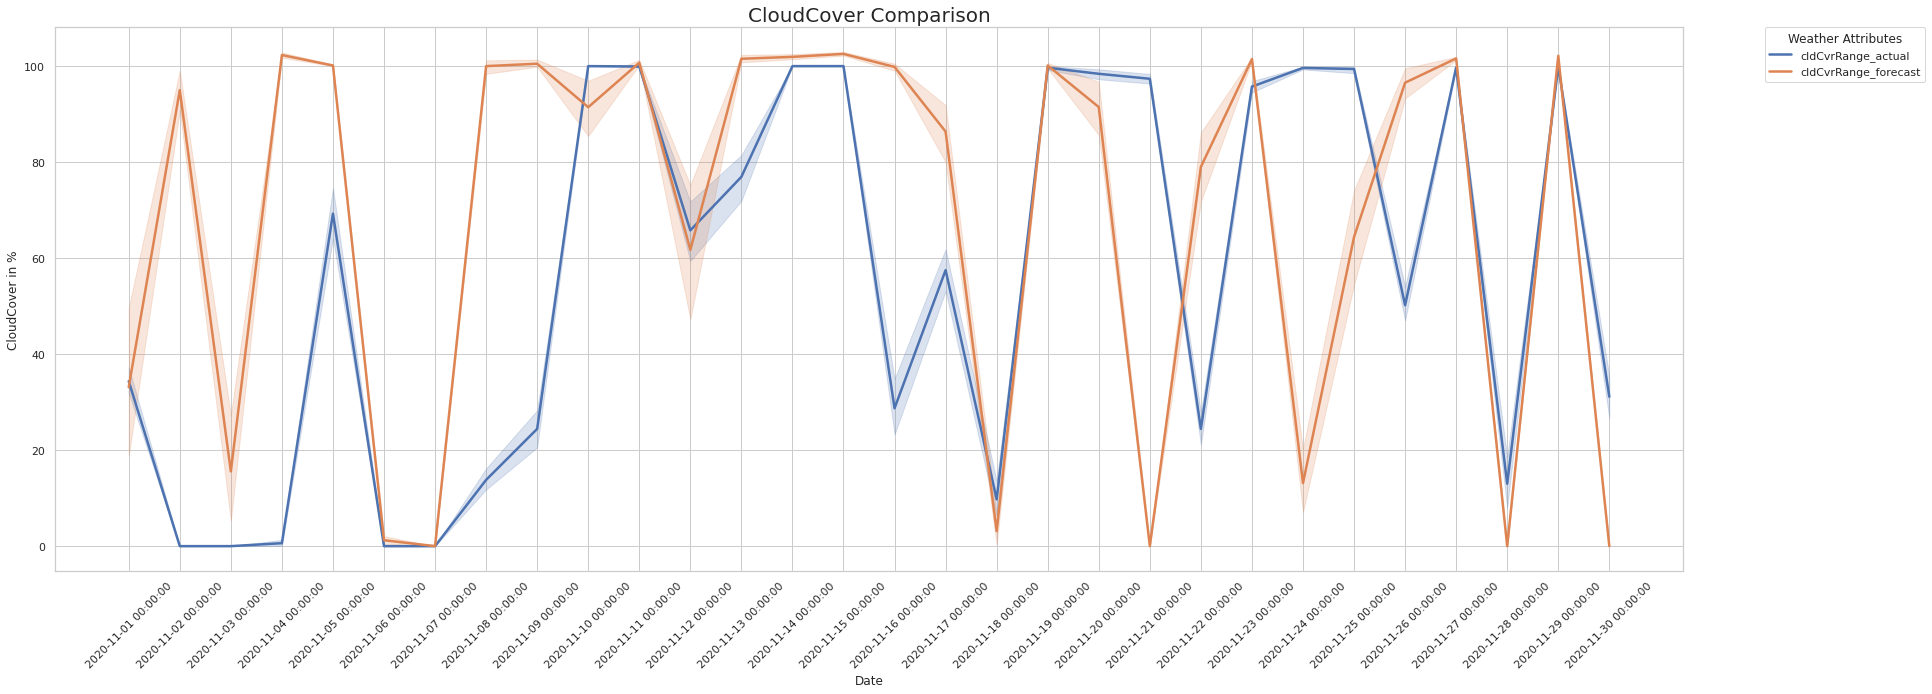

In [12]:
sns.set(rc={'figure.figsize':(26,10)})
sns.set_style("whitegrid")
with plt.rc_context({'lines.linewidth': 2.5}):
    ax = sns.lineplot(x='Date', y='value', hue='variable', 
                  data=pd.melt(merged_weather[['Date', 'cldCvrRange', 'cldCvrRange_forecast']], ['Date']))
    new_labels = ['cldCvrRange_actual', 'cldCvrRange_forecast']
sns.set(rc={"axes.titlesize":20,'figure.facecolor':'white','axes.facecolor':'white'},style="white")
ax.set(xlabel='Date', ylabel='CloudCover in %',title="CloudCover Comparison")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., labels=new_labels, title='Weather Attributes')
plt.xticks(rotation=45)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

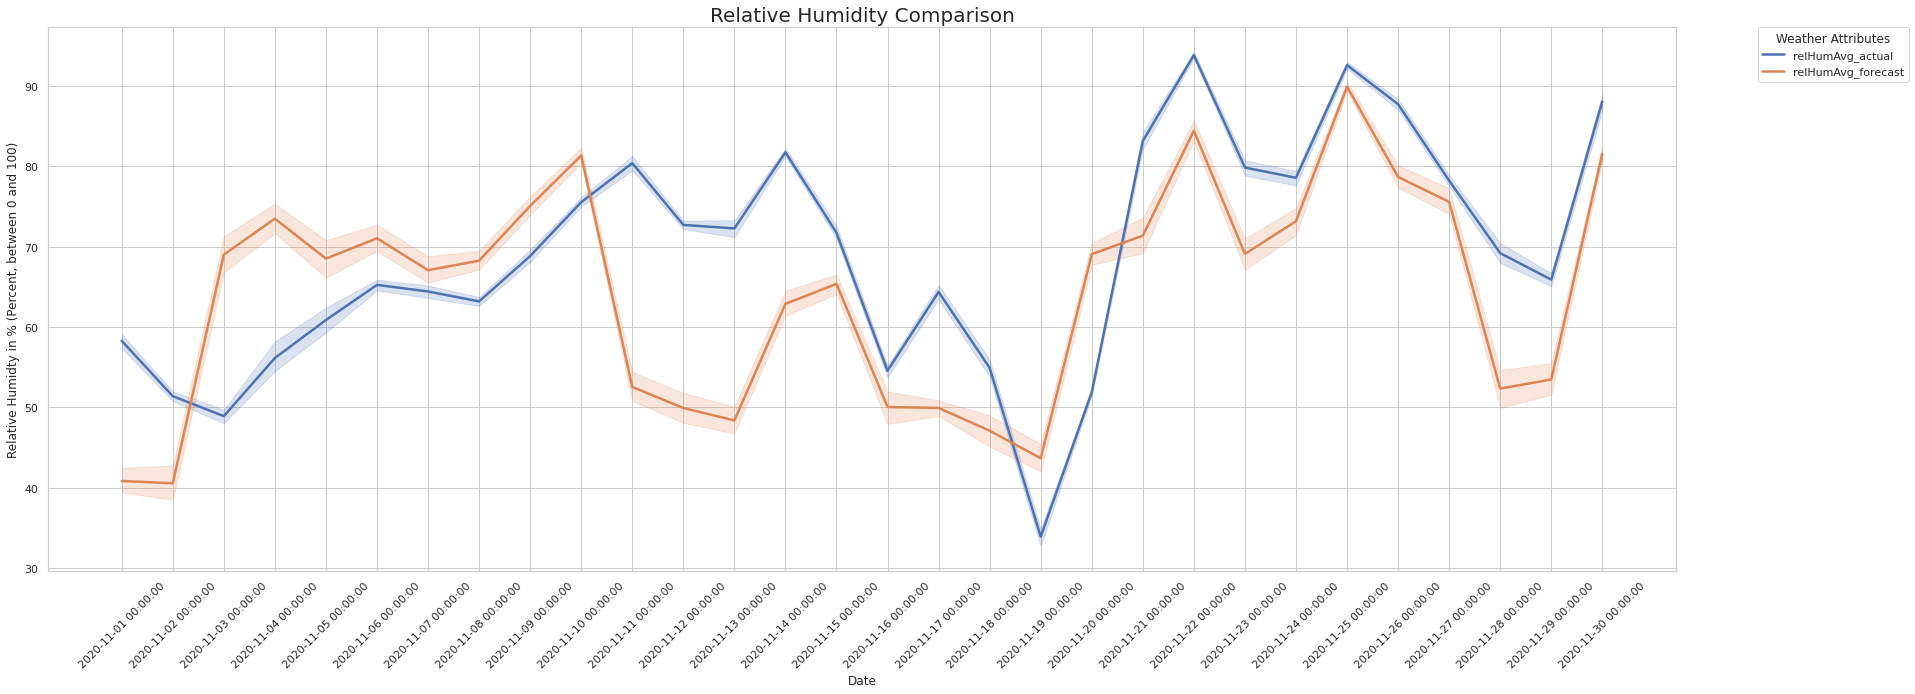

In [13]:
sns.set(rc={'figure.figsize':(26,10)})
sns.set_style("whitegrid")
with plt.rc_context({'lines.linewidth': 2.5}):
    ax = sns.lineplot(x='Date', y='value', hue='variable', 
                  data=pd.melt(merged_weather[['Date', 'relHumAvg', 'relHumAvg_forecast']], ['Date']))
    new_labels = ['relHumAvg_actual', 'relHumAvg_forecast']
sns.set(rc={"axes.titlesize":20,'figure.facecolor':'white','axes.facecolor':'white'},style="white")
ax.set(xlabel='Date', ylabel='Relative Humidty in % (Percent, between 0 and 100)',title="Relative Humidity Comparison")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., labels=new_labels, title='Weather Attributes')
plt.xticks(rotation=45)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

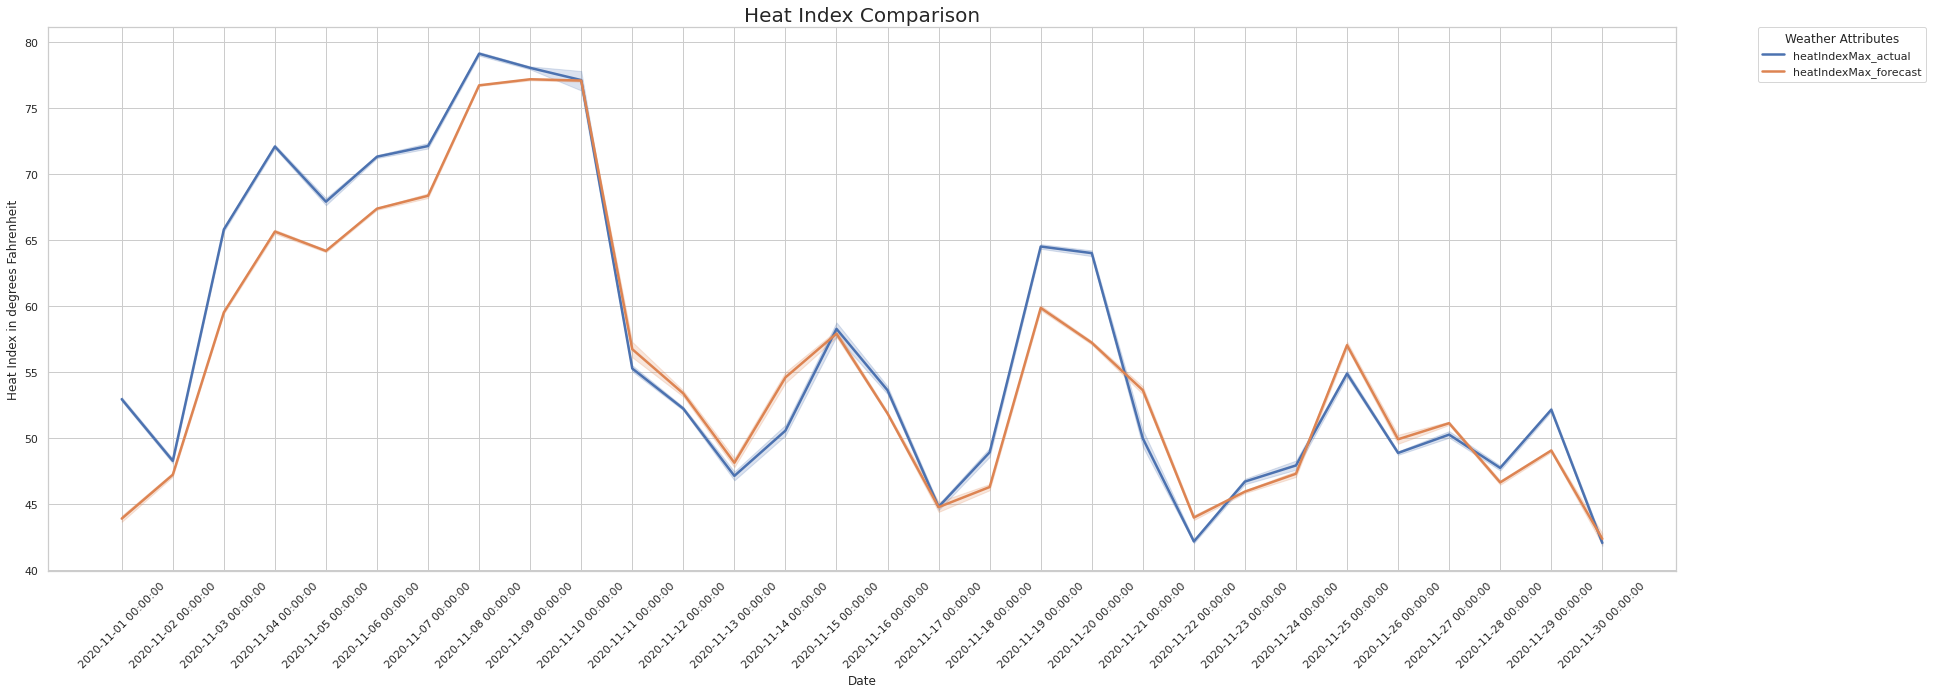

In [14]:
sns.set(rc={'figure.figsize':(26,10)})
sns.set_style("whitegrid")
with plt.rc_context({'lines.linewidth': 2.5}):
    ax = sns.lineplot(x='Date', y='value', hue='variable', 
                  data=pd.melt(merged_weather[['Date', 'heatIndexMax', 'heatIndexMax_forecast']], ['Date']))
    new_labels = ['heatIndexMax_actual', 'heatIndexMax_forecast']
sns.set(rc={"axes.titlesize":20,'figure.facecolor':'white','axes.facecolor':'white'},style="white")
ax.set(xlabel='Date', ylabel='Heat Index in degrees Fahrenheit',title="Heat Index Comparison")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., labels=new_labels, title='Weather Attributes')
plt.xticks(rotation=45)

## **Model Sensitivity to actual and forecasted Weather Attributes**

In [15]:
# calculate rmse scores
def rmse(pred_test, y_test):
    return np.sqrt(((pred_test - y_test) ** 2).mean())

# calculate mape scores
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [16]:
# load hyper paramter tuned random forest model object 
rf_model = pd.read_pickle('gs://aes-analytics-0002-curated/Outage_Restoration/Model_object/Random_Forest_GridSearch_09172020.pkl')

In [17]:
model_col = ['MODEL_NAME' , 'TEST_MSE', 'TEST_RMSE', 'TEST_MAE', 'TEST_MAPE', 'TEST_R2']
model_result_df = pd.DataFrame(columns=model_col)
data_test_list = pd.DataFrame()
i=0

In [18]:
X = df_ads_actuals_v1[rf_final_feautres]
y = np.log(df_ads_actuals_v1.TTR)

y_test_pred = rf_model.predict(X)
y_test_pred = np.exp(y_test_pred)

y = np.exp(y)

mse_test = mean_squared_error(y, y_test_pred)
rmse_test = rmse(y,y_test_pred)
mae_test = mean_absolute_error(y, y_test_pred)
mape_test = mean_absolute_percentage_error(y,y_test_pred)
r2_test = r2_score(y,y_test_pred)

data_test = pd.DataFrame({'Model':'Random Forest Actual', 'Test_Predicted': list(y_test_pred),'Test_Actual': list(y)})
data_test_list = data_test_list.append(data_test)
data_test_list.reset_index(drop=True, inplace=True)

model_result_df.loc[i] = ['Random Forest Actual', mse_test, rmse_test, mae_test, mape_test, r2_test]
i = i + 1

In [19]:
model_result_df

,MODEL_NAME,TEST_MSE,TEST_RMSE,TEST_MAE,TEST_MAPE,TEST_R2
0,Random Forest Actual,91450.87,302.41,180.76,129.94,0.43


In [20]:
X = df_ads_forecats_v1[rf_final_feautres]
y = np.log(df_ads_forecats_v1.TTR)

y_test_pred = rf_model.predict(X)
y_test_pred = np.exp(y_test_pred)

y = np.exp(y)

mse_test = mean_squared_error(y, y_test_pred)
rmse_test = rmse(y,y_test_pred)
mae_test = mean_absolute_error(y, y_test_pred)
mape_test = mean_absolute_percentage_error(y,y_test_pred)
r2_test = r2_score(y,y_test_pred)

data_test = pd.DataFrame({'Model':'Random Forest Forecast', 'Test_Predicted': list(y_test_pred),'Test_Actual': list(y)})
data_test_list = data_test_list.append(data_test)
data_test_list.reset_index(drop=True, inplace=True)

model_result_df.loc[i] = ['Random Forest Forecast', mse_test, rmse_test, mae_test, mape_test, r2_test]
i = i + 1

In [21]:
model_result_df

,MODEL_NAME,TEST_MSE,TEST_RMSE,TEST_MAE,TEST_MAPE,TEST_R2
0,Random Forest Actual,91450.87,302.41,180.76,129.94,0.43
1,Random Forest Forecast,92127.35,303.52,180.22,128.34,0.42


## **Actual vs Fitted Plot**

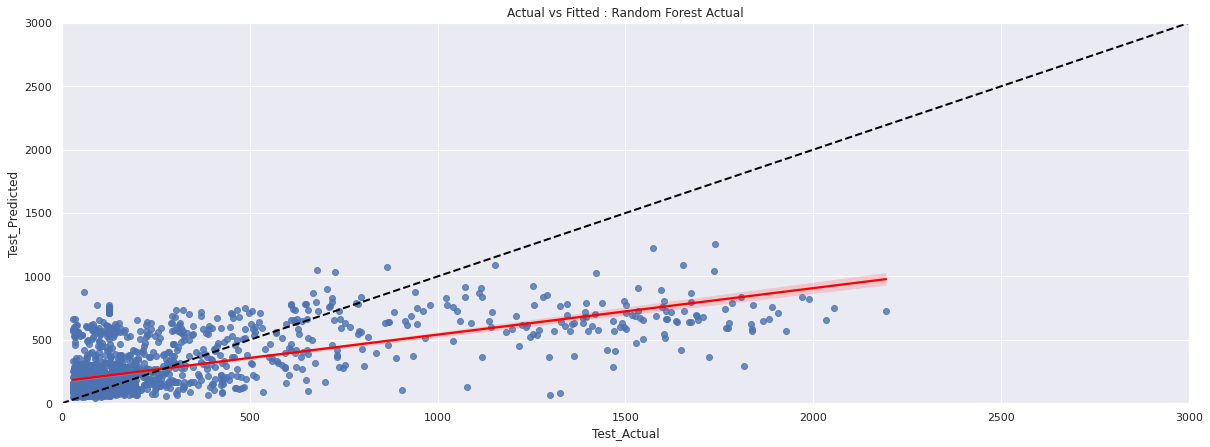

In [22]:
sns.set(rc={'figure.figsize':(18,7)})
sns.set_style("darkgrid")

ax = sns.regplot(x="Test_Actual", y="Test_Predicted", data=data_test_list[data_test_list.Model=='Random Forest Actual'], line_kws={"color": "red"})
ax.set_xlim(0,3000)
ax.set_ylim(0,3000)
ax.set_title('Actual vs Fitted : Random Forest Actual')
points = np.linspace(0, 3000, 100)
ax = sns.lineplot(points, points, color='black', marker=None,linestyle='--', linewidth=2.0)

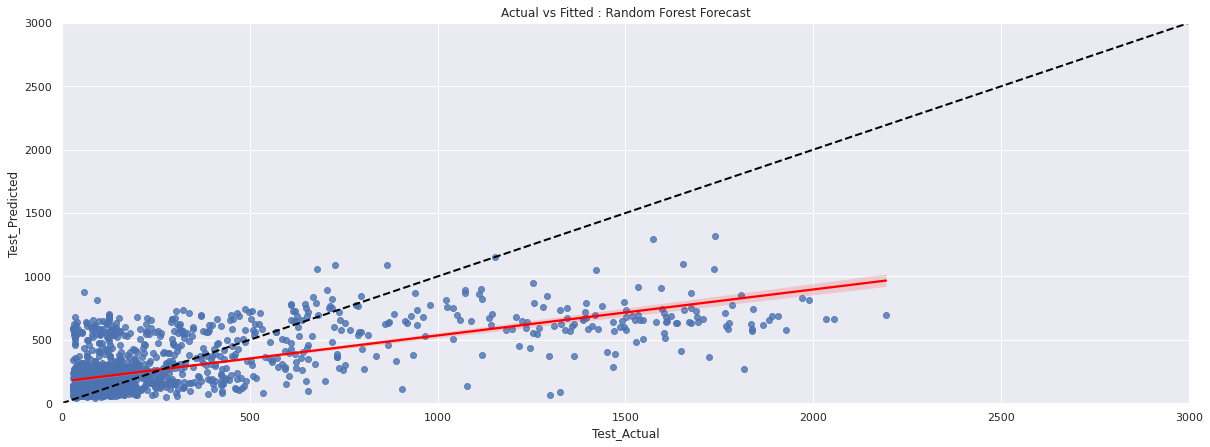

In [23]:
sns.set(rc={'figure.figsize':(18,7)})
sns.set_style("darkgrid")

ax = sns.regplot(x="Test_Actual", y="Test_Predicted", data=data_test_list[data_test_list.Model=='Random Forest Forecast'], line_kws={"color": "red"})
ax.set_xlim(0,3000)
ax.set_ylim(0,3000)
ax.set_title('Actual vs Fitted : Random Forest Forecast')
points = np.linspace(0, 3000, 100)
ax = sns.lineplot(points, points, color='black', marker=None,linestyle='--', linewidth=2.0)